# Making Necessary Imports

In [661]:
# Data Preparation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Models
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

#Metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, adjusted_mutual_info_score
from yellowbrick.cluster import KElbowVisualizer

#Others
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import warnings
import scipy.cluster.hierarchy as sch
warnings.filterwarnings('ignore')

# Get the data

In [716]:
df = pd.read_csv('quake.csv', encoding='utf-8')
df.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


# EDA (5%)

In [4]:
print('Number of NULL values in each feature\n')
print(df.isnull().sum())
print('======================================================')

print('\nGeneral Info about Dataset\n')
print(df.info())
print('======================================================')

print('\nDescription of features \n')
print(df.describe())

Number of NULL values in each feature

Focal depth    0
Latitude       0
Longitude      0
Richter        0
dtype: int64

General Info about Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB
None

Description of features 

       Focal depth     Latitude    Longitude      Richter
count  2178.000000  2178.000000  2178.000000  2178.000000
mean     74.359963     7.961997    54.914835     5.977181
std     116.467797    30.545583   118.875581     0.189426
min       0.000000   -66.490000  -179.960000     5.800000
25%      21.000000   -12.432500   -67.782500     5.800000
50%      39.000000     0.210000   122.100000     5.900000
75% 

There are no missing values in the dataset

There are 2178 values and 4 features (Focal depth, Latitude, Longitude, Richter) and it takes 68.2 KB Memory

1 int and 3 float type features

There are some outliers in Focal Depth, and possible Latitude and Longitude, the Richter looks fine

In [5]:
df[df.duplicated(keep=False)]

,Focal depth,Latitude,Longitude,Richter
1641,0,49.87,78.97,5.9
1994,0,49.87,78.97,5.9


## Univariate Analysis

array([[<Axes: title={'center': 'Focal depth'}>,
        <Axes: title={'center': 'Latitude'}>],
       [<Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Richter'}>]], dtype=object)

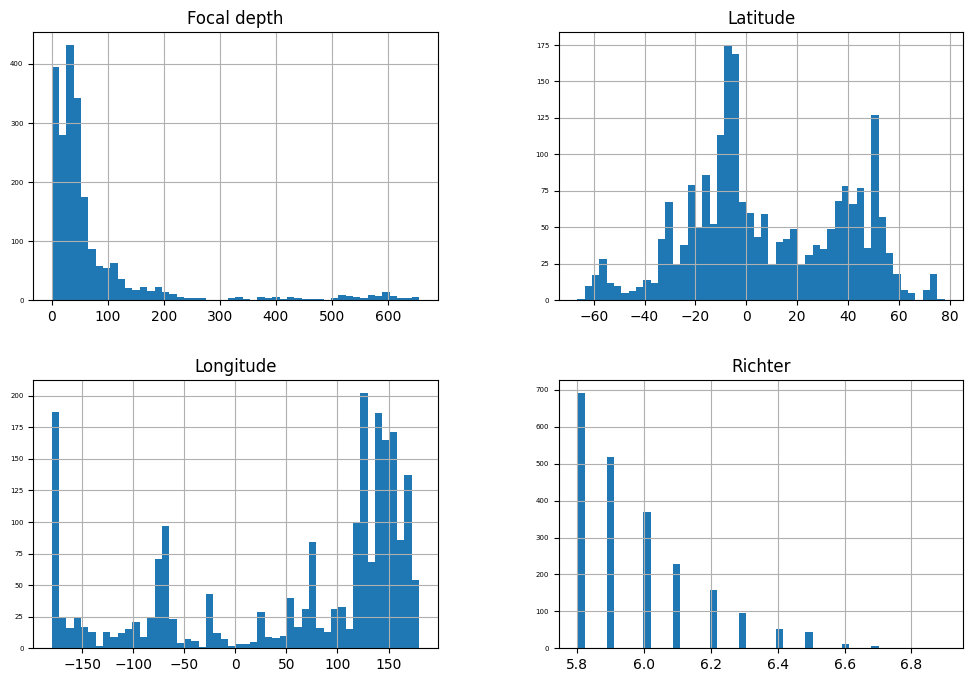

In [6]:
df.hist(figsize=(12,8), bins=50, xlabelsize=10, ylabelsize=5)

**Focal Depth** is skewed rightly and suggests that most of the earthquakes occure at lower focal depth which might be very valuable insight

We see that **latitude** is somewhat bimodal, and certain latitude regions tend to have most earthquakes

**Longitude** also shows the regions with high chances of earthquakes and can lead to better division for clusters

**Richter** scale is rightly skews and show the pretty normal distribution for such scale, suggesting that lower scale earthquakes are more common than high values

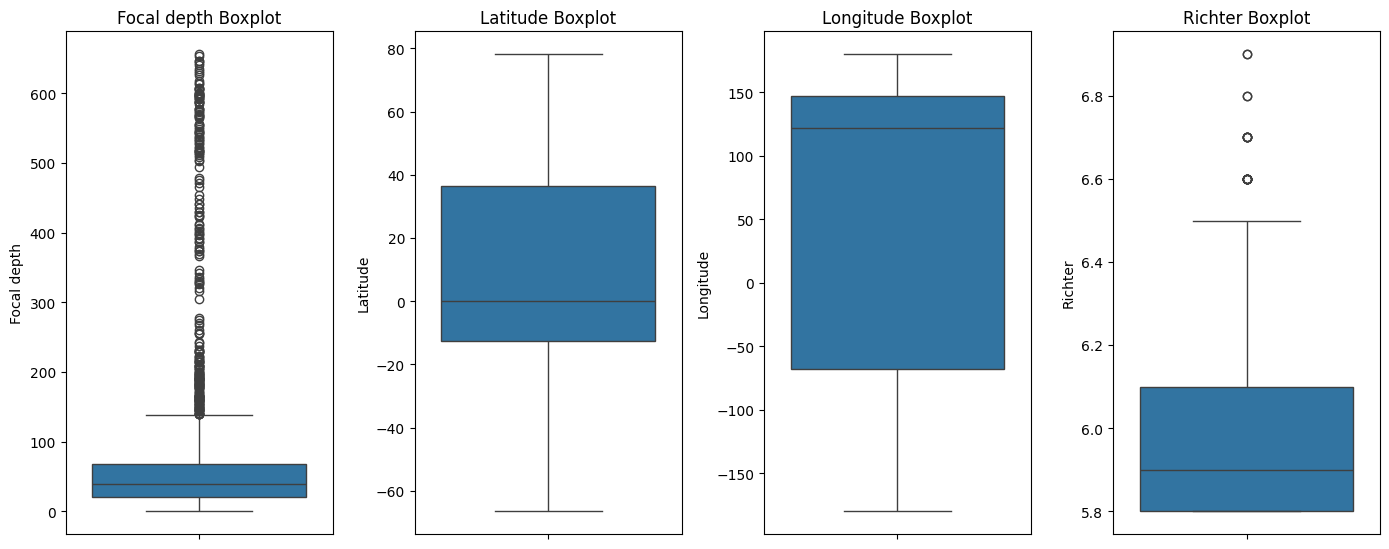

In [7]:
plt.figure(figsize=(14,16))
for i, col in enumerate(df.columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df[col])
    plt.title(f'{col} Boxplot')
    plt.tight_layout()
plt.show()

Boxplot of Focal Depth proves the point that it contains a lot of outliers

Other Boxplots do not show much significant information except that Richter has 4 outliers

In [8]:
print(f'The skewness of Focal Depth : {df['Focal depth'].skew()}')
print(f'The kurtosis of Focal Depth : {df['Focal depth'].kurtosis()}')

The skewness of Focal Depth : 3.2759523852397505
The kurtosis of Focal Depth : 10.796760983139265


## Multivariate Analysis

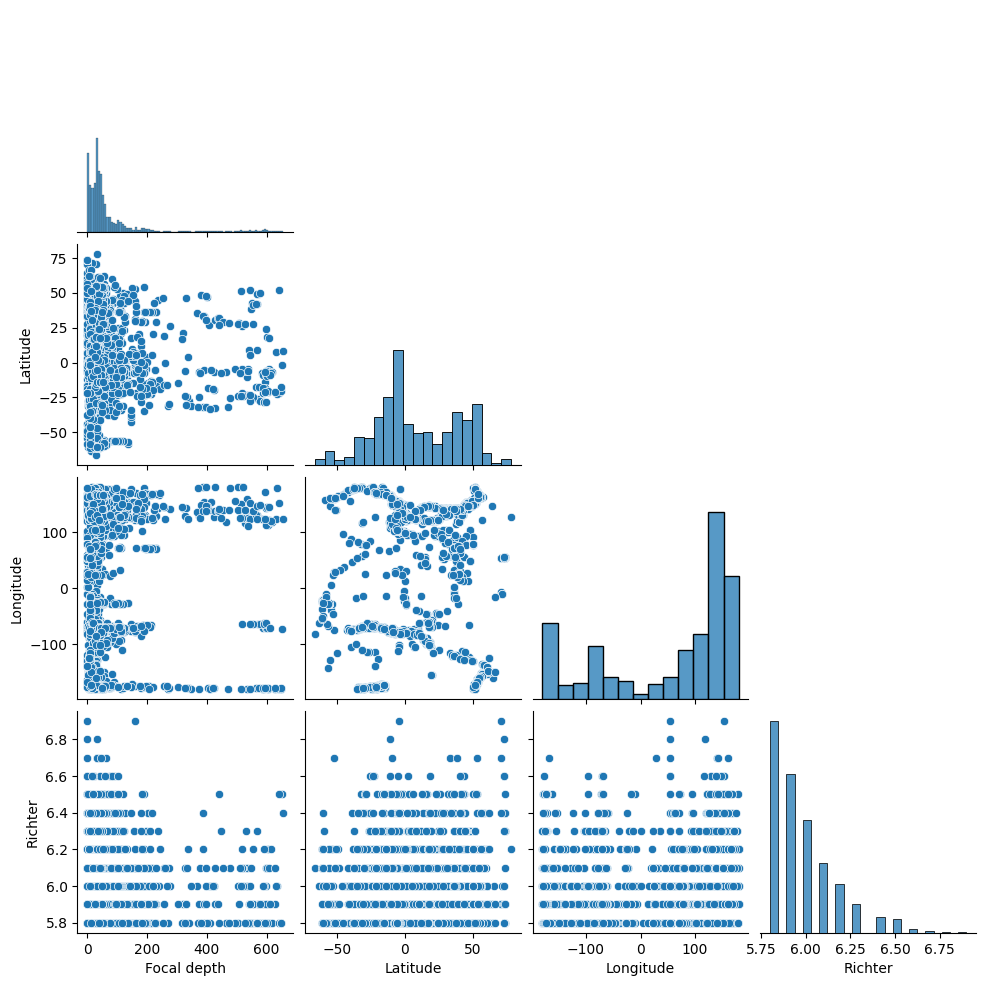

In [9]:
sns.pairplot(data=df, corner=True)
plt.show()

Visually I do not see any kind of correlation

In longitude as it goes over and below 100 and -100 respectively, the Focal Depth tends to increase

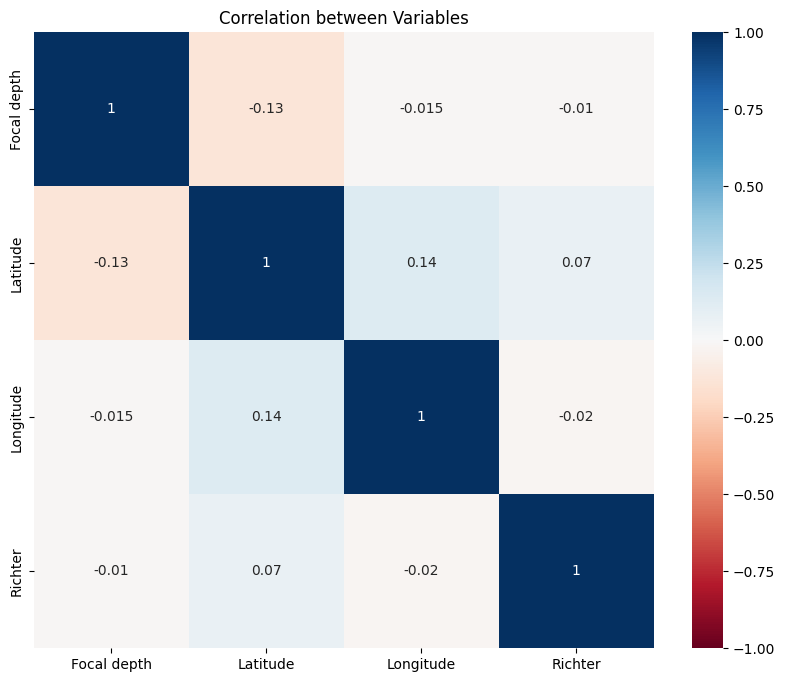

In [10]:
correlation = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation, annot=True, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Correlation between Variables')
plt.show()

There are no strong correlation between two variables

The best correlations are shown between (**latitude**, **focal depth**), however it is still not very strong

### **Quick Summary**

There are no missing values

There are outliers in Focal Depth 

Focal Depth is Right skewed

There are no significant correlation between features

The data needs to be normalized since they all have different scales

# Data Preparation (5%)

## Deal with Outliers

In [717]:
q1 = df['Focal depth'].quantile(0.25)
q3 = df['Focal depth'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
median = df['Focal depth'].median()

In [718]:
len(df[(df['Focal depth'] < lower_bound) | (df['Focal depth'] > upper_bound)]) / len(df)

0.11294765840220386

This shows that 11% of the whole dataset contains the rows with outliers of Focal depth

We can not just remove those outliers because that is significant part of the dataset

That's why I will impute the outliers with median since median is robust to outliers

In [719]:
df.loc[df['Focal depth'] < lower_bound, 'Focal depth'] = median
df.loc[(df['Focal depth'] > upper_bound), 'Focal depth'] = median

In [720]:
len(df[(df['Focal depth'] < lower_bound) | (df['Focal depth'] > upper_bound)]) / len(df)

0.0

As we see, there are 0 Focal depth values that lie outside original boundaries

<Axes: >

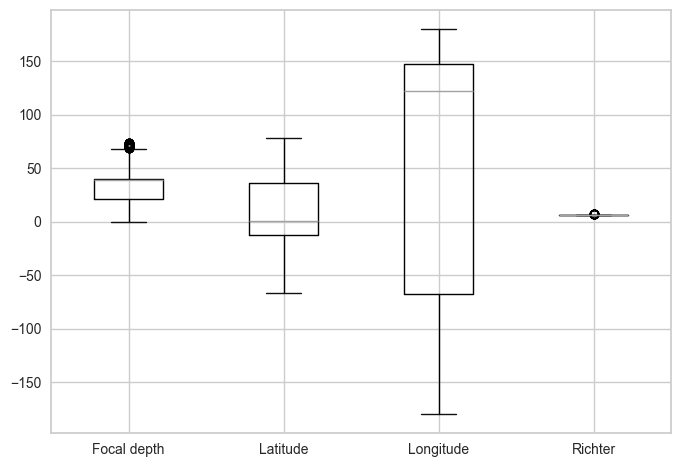

In [715]:
df.boxplot()

Now it is 0 rows with outliers

## Feature Scaling

In [15]:
standard_scaler = StandardScaler()
df_scaled = standard_scaler.fit_transform(df)

# K Means

## Helper function

In [772]:
# def plot_kmeans_3d(df_scaled, kmeans, tsne_use=False):
#     k = kmeans.n_clusters
#     clusters = kmeans.labels_
#     clusters_center = kmeans.cluster_centers_
    
#     pca = PCA(n_components=3)
#     tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)

#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')

#     if tsne_use:
#         df_reduced = tsne.fit_transform(df_scaled)
#         name = 't-SNE'
#     else:
#         df_reduced = pca.fit_transform(df_scaled)
#         reduced_centers = pca.transform(clusters_center)
#         name = 'PCA'

#     scatter = ax.scatter(df_reduced[:, 0], df_reduced[:, 1], df_reduced[:, 2], c=clusters, cmap='viridis', marker='o', alpha=0.5)

#     if not tsne_use:
#         # Plot cluster centers for PCA
#         ax.scatter(reduced_centers[:, 0], reduced_centers[:, 1], reduced_centers[:, 2], marker='X', c='red', alpha=1, s=200)

#     plt.colorbar(scatter)
#     ax.set_title(f'{kmeans.__class__.__name__} with {k} Clusters with {name}')
#     ax.set_xlabel('Component 1')
#     ax.set_ylabel('Component 2')
#     ax.set_zlabel('Component 3')
#     plt.show()

# def plot_kmeans(df_scaled, kmeans, tsne_use=False):
#     k = kmeans.n_clusters
#     clusters = kmeans.labels_
#     clusters_center = kmeans.cluster_centers_
    
#     pca = PCA(n_components=2)
#     tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    

#     plt.figure(figsize=(8, 6))
#     if tsne_use:
#         df_reduced = tsne.fit_transform(df_scaled)
#         name = 't-SNE'
#         scatter = plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
#     else:
#         df_reduced = pca.fit_transform(df_scaled)
#         name = 'PCA'
#         reduced_centers = pca.transform(clusters_center)
#         scatter = plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
#         plt.scatter(x=reduced_centers[:, 0], y=reduced_centers[:, 1], marker='X', c='red', alpha=1, s=200)

    
#     plt.colorbar(scatter)
#     plt.title(f'{kmeans.__class__.__name__} with {k} Clusters with {name}')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.show()

def plot_kmeans(df_scaled, kmeans):
    k = kmeans.n_clusters
    labels = kmeans.labels_
    clusters_center = kmeans.cluster_centers_


    plt.scatter(df_scaled[:, 2], df_scaled[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
    plt.scatter(clusters_center[:, 2], clusters_center[:, 1], marker='X', c='red', alpha=1, s=200)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{kmeans.__class__.__name__} with {k} Clusters')
    plt.show()


def plot_data(df_scaled):

    plt.scatter(df_scaled[:, 2], df_scaled[:, 1], cmap='viridis', marker='o', alpha=0.5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Visualisation of Data')
    plt.show()

# def plot_data(df_scaled, tsne_use=False, c=None):
#     if tsne_use:
#         tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
#         df_reduced = tsne.fit_transform(df_scaled)
#         name = 't-SNE'
#     else:
#         pca = PCA(n_components=2)
#         df_reduced = pca.fit_transform(df_scaled)
#         name = 'PCA'


#     scatter = plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=c, cmap='viridis', marker='o', alpha=0.9)

#     plt.colorbar(scatter)
#     plt.title(f'Visualisation of data with {name}')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.show()


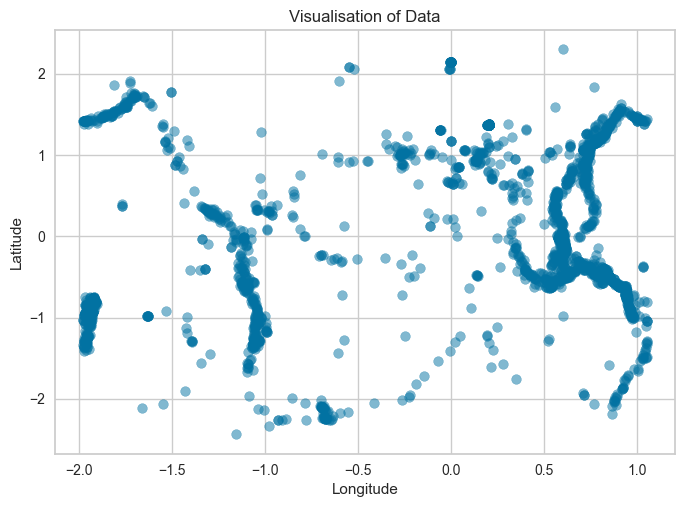

In [771]:
plot_data(df_scaled)

As we see the visualisation look better with t-SNE dimensionality reduction because there is easier division of clusters visually

## KMeans with 15 Clusters (5%)

In [418]:
kmeans_15k = KMeans(n_clusters=15, random_state=42)
kmeans_15k.fit(df_scaled)

KMeans(n_clusters=15, random_state=42)

Visualise the KMeans with 15 clusters

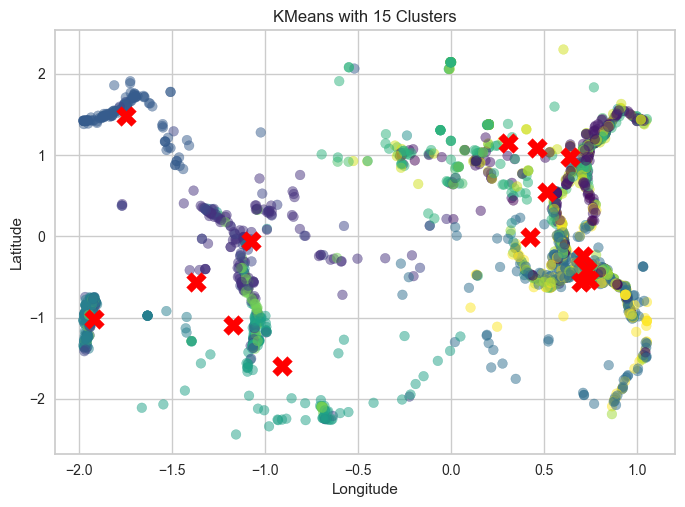

In [766]:
plot_kmeans(df_scaled, kmeans_15k)

**Quick Summary :**

As we see 15 clustered KMeans is not really good model that helps to distinguish clusters

Most of the clusters are highly overlapped with each other

Thus, 15 is not good value for K

## Find Optimal Value for K

### Gap statistics (5%)

In [420]:
def optimalK_gap(data, nrefs=3, maxClusters=15):
    gaps = np.zeros(maxClusters - 1)

    df_results = pd.DataFrame({'clusterCount' : [], 'gap' : []})

    for gap_index, k in enumerate(range(1, maxClusters)):

        refDisp = np.zeros(nrefs)

        for i in range(nrefs):
            randomRef = np.random.random_sample(size=data.shape)
            kmeans = KMeans(k, random_state=42)
            kmeans.fit(randomRef)
            refDisp[i] = kmeans.inertia_
        
        kmeans = KMeans(k, random_state=42)
        kmeans.fit(data)
        
        origDisp = kmeans.inertia_

        gap = np.log(np.mean(refDisp)) - np.log(origDisp)

        gaps[gap_index] = gap

        df_results = pd.concat([df_results, pd.DataFrame({'clusterCount': [k], 'gap': [gap]})], ignore_index=True)

    return gaps.argmax() + 1, df_results

Text(0, 0.5, 'Gap')

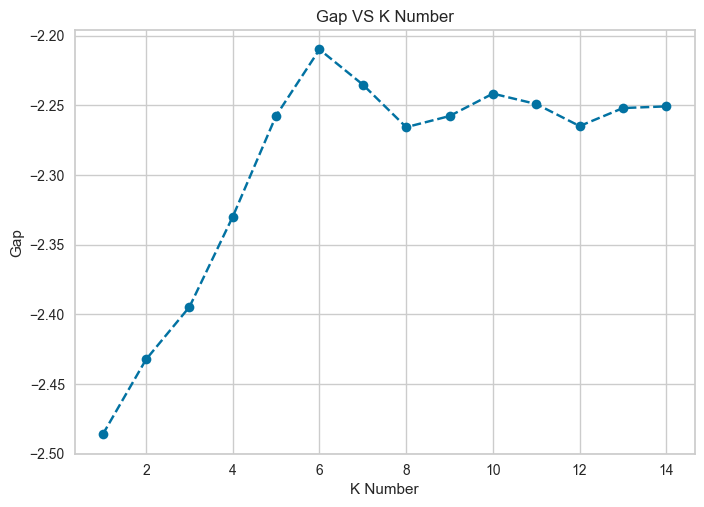

In [421]:
score_gap, df_gaps = optimalK_gap(df_scaled, nrefs=5, maxClusters=15)
plt.plot(df_gaps['clusterCount'], df_gaps['gap'], marker='o', linestyle='--', color='b')
plt.title('Gap VS K Number')
plt.xlabel('K Number')
plt.ylabel('Gap')

According to graph we need to choose 6 clusters because it reaches the maximum gap value at given point

### Elbow method (5%)

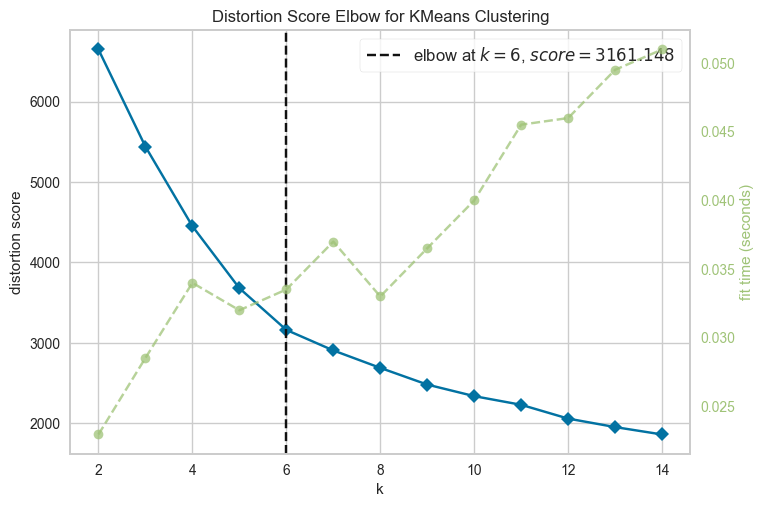

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [422]:
visualizer = KElbowVisualizer(KMeans(), k=(2, 15), timings=True)
visualizer.fit(df_scaled)
visualizer.show()

According to our Elbow method we need to choose 6 clusters for this dataset

Since two metrics agreed on the number 6, I will choose this value for further implementation of KMeans Algorithm


In [750]:
silhouette_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

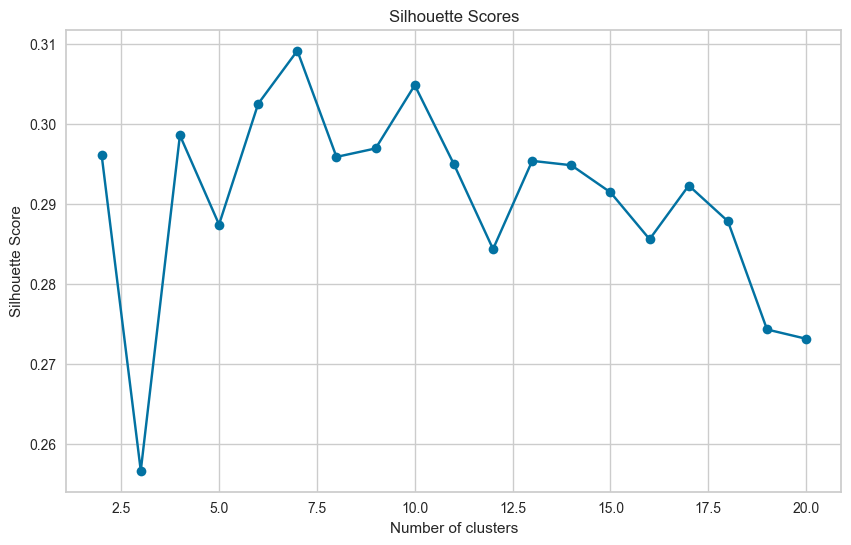

In [751]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

### KMeans Model with optimal K value

In [723]:
kmeans_6k = KMeans(n_clusters=6, random_state=42)
kmeans_6k.fit(df_scaled)

KMeans(n_clusters=6, random_state=42)

### Minibatch KMeans Model with optimal K value

In [724]:
minikmeans_6k = MiniBatchKMeans(n_clusters=6, random_state=42)
minikmeans_6k.fit(df_scaled)

MiniBatchKMeans(n_clusters=6, random_state=42)

## Visualization for obtained clusters (5%)

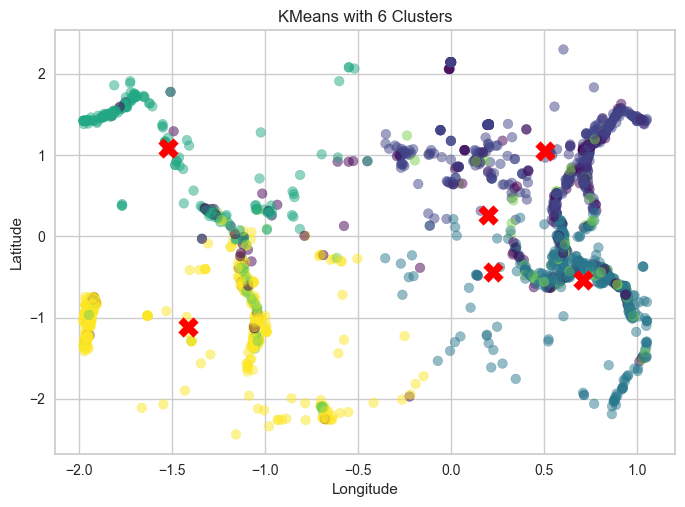

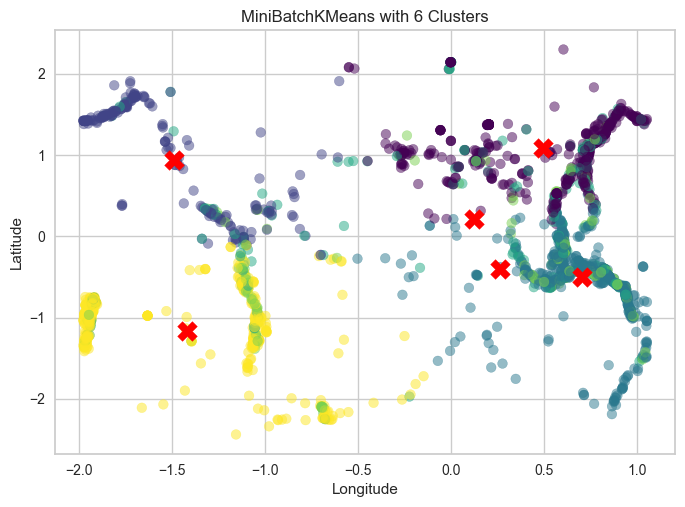

In [773]:
plot_kmeans(df_scaled, kmeans_6k)
plot_kmeans(df_scaled, minikmeans_6k)

## Comparison and Conclusion (5%)

Models with 6 Clusters are much better than 15 Clustered model, because there are some level of separability between clusters and much less overlapping between them

However, the models are not perfect because there are still considerable amount of overlapping and noises that worsen our models

The difference between Kmeans and MiniBatch KMeans are minimal

As we see most of the clusters are not circle shaped, that is why the KMeans algorithm might not be the most preferrable choice

# Other Clustering Algorithms (20%)

### Helper function

In [783]:
def plot_dbscan(df_scaled, dbscan):
    labels = dbscan.labels_
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):

        alpha = 0.7
        markersize = 6

        if k == -1:
            col = [0, 0, 0, 1]
            alpha = 1
            markersize = 3

        class_member_mask = (labels == k)

        xy = df_scaled[class_member_mask]

        plt.plot(xy[:, 2], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=markersize, alpha=alpha)

    
    plt.title(f'DBSCAN Visualization')
    plt.xlabel('Longitude 1')
    plt.ylabel('Latitude 2')

    plt.show()

# def plot_dbscan(df_scaled, dbscan, tsne=False):

#     if tsne:
#         tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
#         df_reduced = tsne.fit_transform(df_scaled)
#         name = 't-SNE'
#     else:    
#         pca = PCA(n_components=2)
#         df_reduced = pca.fit_transform(df_scaled)
#         name = 'PCA'
        

#     labels = dbscan.labels_

#     plt.figure(figsize=(10,8))

#     unique_labels = set(labels)
#     colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

#     for k, col in zip(unique_labels, colors):

#         alpha = 0.7

#         if k == -1:
#             col = [0, 0, 0, 1]
#             alpha = 1

#         class_member_mask = (labels == k)

#         xy = df_reduced[class_member_mask]

#         plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=4, alpha=alpha)

    
#     plt.title(f'DBSCAN Visualization with {name}')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')

#     plt.show()


## DBSCN Model

In [787]:
dbscan = DBSCAN()
dbscan.fit(df_scaled)

DBSCAN()

In [788]:
print('Number of clusters ', len(set(dbscan.labels_)))

Number of clusters  36


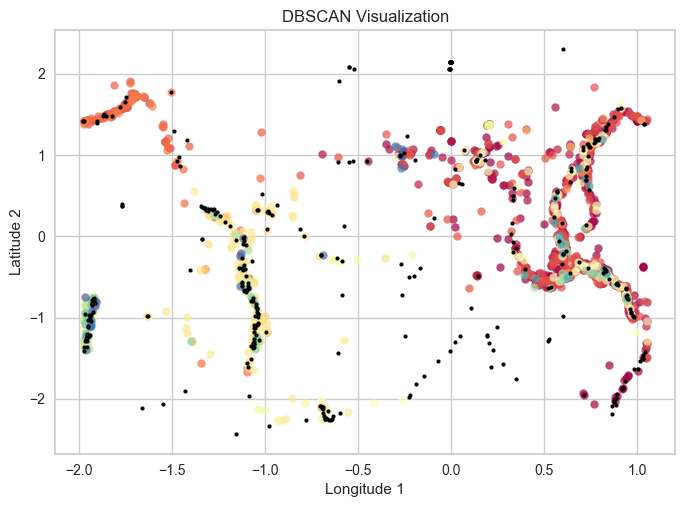

In [789]:
plot_dbscan(df_scaled, dbscan)
# plot_dbscan(df_scaled, dbscan, tsne=True)

### Find Optimal eps and min_samples values

I will use K nearest neighbors method to find the optimal epsilon value 

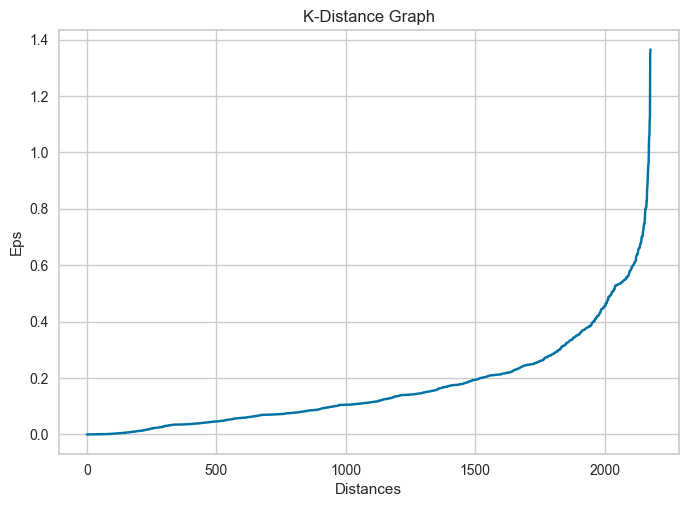

In [429]:
nneighs = NearestNeighbors(n_neighbors=8)
nbrs = nneighs.fit(df_scaled)

distances, indeces = nbrs.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Distances')
plt.ylabel('Eps')
plt.show()

According to graph, maximum curvature point is around 0.4 to 0.6

Now I will try different combination so of epsilons with min samples starting from 8 to 46 min_samples, 8 because 2 * num of features and 46 because sqrt(num instances in dataset) = 46

In [555]:
epsilons = np.arange(0.4, 0.6, 0.01)
min_samples = range(8, 46)
scores = pd.DataFrame({'eps' :[], 'min_sample': [], 'score' : []})

for eps in epsilons:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample, )
        dbscan.fit(df_scaled)
        if len(set(dbscan.labels_)) > 1:  # Check if there is more than one cluster
            score = silhouette_score(df_scaled, dbscan.labels_)
        else:
            score = -1  # Assigning a bad score if only one cluster (or only noise)

        # Append the new row of results to the scores DataFrame
        scores = pd.concat([scores, pd.DataFrame({'eps': [eps], 'min_sample': [min_sample], 'score': [score]})], axis=0)

# You may want to reset the index of your DataFrame
scores = scores.reset_index(drop=True)

In [556]:
scores.sort_values(by='score', ascending=False)[scores['score'] > 0].head()

,eps,min_sample,score
690,0.58,14.0,0.220634
730,0.59,16.0,0.217162
652,0.57,14.0,0.213686
731,0.59,17.0,0.212465
692,0.58,16.0,0.207357


In [800]:
dbscan = DBSCAN(eps=0.58, min_samples=14)
dbscan.fit(df_scaled)
print('Number of clusters ', len(set(dbscan.labels_)))

Number of clusters  4


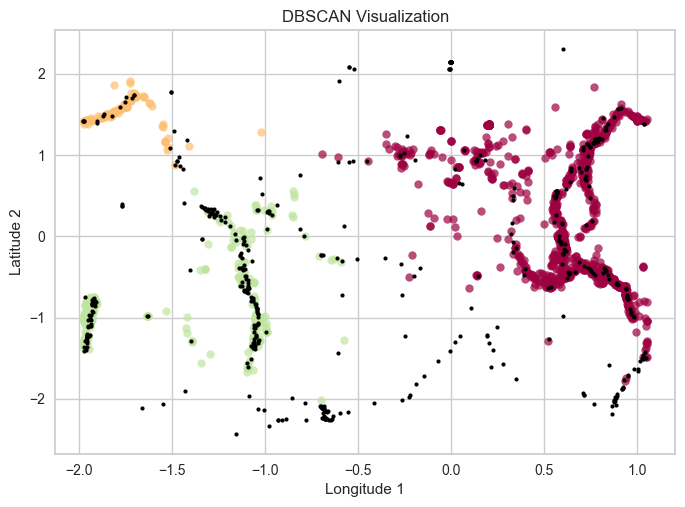

In [801]:
plot_dbscan(df_scaled, dbscan)
# plot_dbscan(df_scaled, dbscan, tsne=True)

## Hierarchical Clustering

In [813]:
def plot_hclust(df_scaled, hclust):
    k = hclust.n_clusters
    labels = hclust.labels_

    plt.scatter(df_scaled[:, 2], df_scaled[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{hclust.__class__.__name__} with {k} Clusters')
    plt.show()

In [635]:
def plot_dendogram(df_scaled, method):
    sch.dendrogram(sch.linkage(df_scaled, method=method))
    plt.title('Dendrogram')
    plt.xlabel('Customers')
    plt.ylabel('Euclidean distances')
    plt.show()

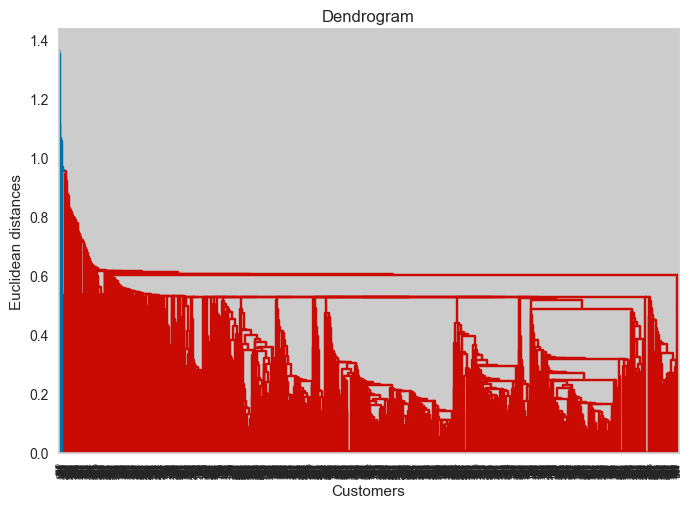

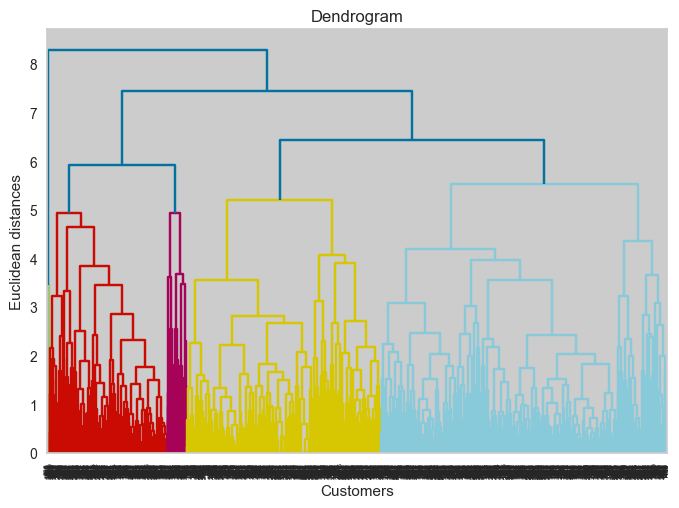

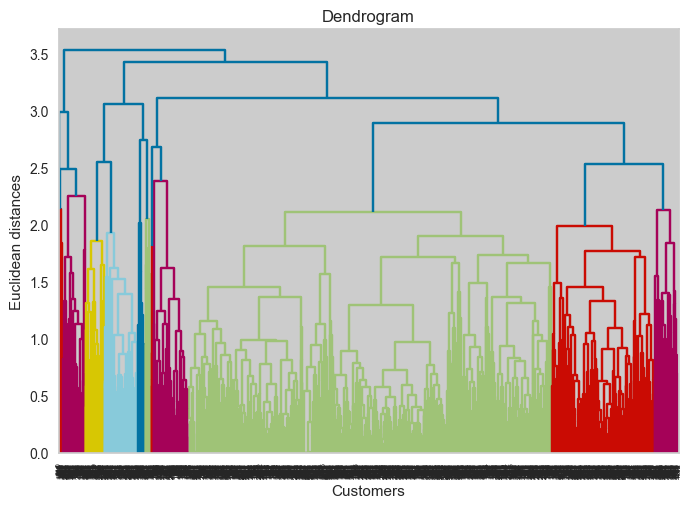

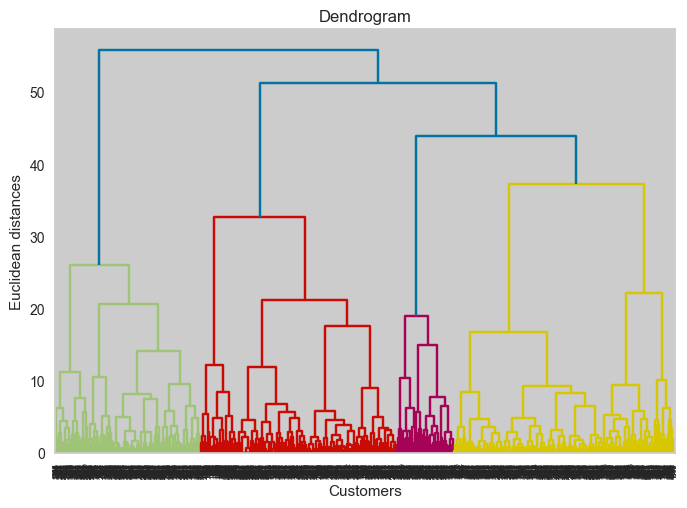

In [636]:
plot_dendogram(df_scaled,'single')
plot_dendogram(df_scaled,'complete')
plot_dendogram(df_scaled,'average')
plot_dendogram(df_scaled,'ward')

By finding the longest vertical line (indicates significant distance increase between merged clusters) on the dendogram we can count the number of optimal clusters for the given dendogram:

5 clusters - complete

11 clusters - average

4 clusters - ward

I will not try single, cause dendogram does not look well

In [802]:
hclust = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
hclust.fit(df_scaled)
silhouette_score(df_scaled, hclust.labels_)

0.18520123134191707

In [803]:
hclust = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hclust.fit(df_scaled)
silhouette_score(df_scaled, hclust.labels_)

0.24346204106491748

In [815]:
hclust = AgglomerativeClustering(n_clusters=11, affinity='euclidean', linkage='average')
hclust.fit(df_scaled)
silhouette_score(df_scaled, hclust.labels_)

0.2584012242928778

According to results Hierarchial clustering shows best results with "Average" Linkage and with 11 clusters

Below is the visualization of how the best model divides data into clusters

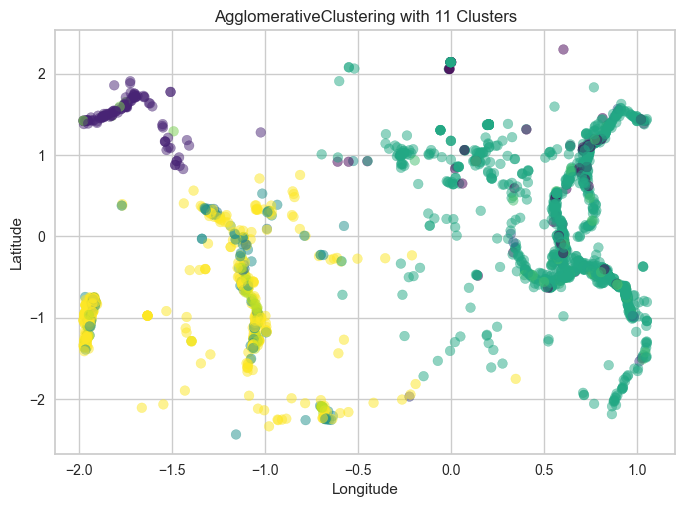

In [816]:
plot_hclust(df_scaled, hclust)
# plot_data(df_scaled, tsne_use=True, c=hclust.labels_)

### Hyperparameter Tuning

I will try different combination of parameters

I chose 4 and 11 as boundaries because as previously found on dendograms these are the minimum and maximum values of clusters

I will not use single linkage because on dendogram it poorly divided clusters

In [642]:
n_clusters = range(4, 11, 1)
linkage_methods = ['complete', 'average', 'ward']


for n_cluster in n_clusters:
    for linkage in linkage_methods:
        hclust = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage)
        hclust.fit(df_scaled)

        silhouette_avg = silhouette_score(df_scaled, hclust.labels_)
        print(f"Clusters: {n_cluster}, Linkage: {linkage}, Silhouette Score: {silhouette_avg}")

Clusters: 4, Linkage: complete, Silhouette Score: 0.19907063510174433
Clusters: 4, Linkage: average, Silhouette Score: 0.21413443378561997
Clusters: 4, Linkage: ward, Silhouette Score: 0.24346204106491748
Clusters: 5, Linkage: complete, Silhouette Score: 0.18520123134191707
Clusters: 5, Linkage: average, Silhouette Score: 0.1991266454524967
Clusters: 5, Linkage: ward, Silhouette Score: 0.22744123572245806
Clusters: 6, Linkage: complete, Silhouette Score: 0.18699314258920313
Clusters: 6, Linkage: average, Silhouette Score: 0.18558900201701595
Clusters: 6, Linkage: ward, Silhouette Score: 0.25632855466272314
Clusters: 7, Linkage: complete, Silhouette Score: 0.18073934920511062
Clusters: 7, Linkage: average, Silhouette Score: 0.27665989997020096
Clusters: 7, Linkage: ward, Silhouette Score: 0.26099968001267326
Clusters: 8, Linkage: complete, Silhouette Score: 0.17492099235679084
Clusters: 8, Linkage: average, Silhouette Score: 0.2713738012842087
Clusters: 8, Linkage: ward, Silhouette Scor

By visual inspection the best score is 0.276  is achieved by 7 clusters and average linkage

In [817]:
hclust = AgglomerativeClustering(n_clusters=7, linkage='average')
hclust.fit(df_scaled)

AgglomerativeClustering(linkage='average', n_clusters=7)

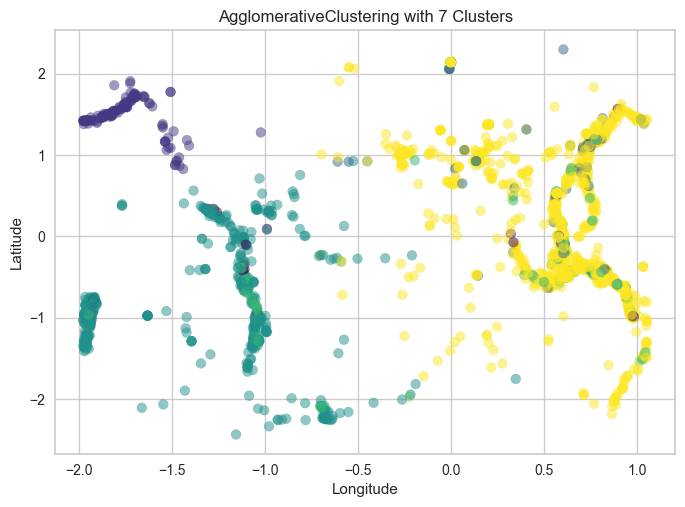

In [818]:
plot_hclust(df_scaled, hclust)

# Evaluation of Models (20%) with comments and conclusion (5%)

## Internal Metrics

In [730]:
kmeans_silhouette_avg = silhouette_score(df_scaled, kmeans_6k.labels_)
kmeans_calinski_harabasz = calinski_harabasz_score(df_scaled, kmeans_6k.labels_)
print(f"KMeans Results: \nAverage Silhouette Score: {kmeans_silhouette_avg}\nCalinski-Harabasz Index: {kmeans_calinski_harabasz}")    
print('Davis Bouldin Score: ', davies_bouldin_score(df_scaled, kmeans_6k.labels_))


KMeans Results: 
Average Silhouette Score: 0.30253963138712875
Calinski-Harabasz Index: 762.7894294892718
Davis Bouldin Score:  1.059561164579684


In [731]:
minikmeans_6k_silhouette_avg = silhouette_score(df_scaled, minikmeans_6k.labels_)
minikmeans_6k_calinski_harabasz = calinski_harabasz_score(df_scaled, minikmeans_6k.labels_)
print(f"MiniBatch KMeans Results: \nAverage Silhouette Score: {minikmeans_6k_silhouette_avg}\nCalinski-Harabasz Index: {minikmeans_6k_calinski_harabasz}")   
print('Davis Bouldin Score: ', davies_bouldin_score(df_scaled, minikmeans_6k.labels_))

MiniBatch KMeans Results: 
Average Silhouette Score: 0.30212907913287074
Calinski-Harabasz Index: 760.1544599589348
Davis Bouldin Score:  1.0717450713282644


In [732]:
dbscan_silhouette_avg = silhouette_score(df_scaled, dbscan.labels_)
dbscan_calinski_harabasz = calinski_harabasz_score(df_scaled, dbscan.labels_)
print(f"DBSCAN Results: \nAverage Silhouette Score: {dbscan_silhouette_avg}\nCalinski-Harabasz Index: {dbscan_calinski_harabasz}")   
print('Davis Bouldin Score: ', davies_bouldin_score(df_scaled, dbscan.labels_))

DBSCAN Results: 
Average Silhouette Score: 0.22063424059299613
Calinski-Harabasz Index: 314.0328023577017
Davis Bouldin Score:  1.9137713378959975


In [733]:
hclust_silhouette_avg = silhouette_score(df_scaled, hclust.labels_)
hclust_calinski_harabasz = calinski_harabasz_score(df_scaled, hclust.labels_)
print(f"Hierarchial Clustering Results: \nAverage Silhouette Score: {hclust_silhouette_avg}\nCalinski-Harabasz Index: {hclust_calinski_harabasz}")   
print('Davis Bouldin Score: ', davies_bouldin_score(df_scaled, hclust.labels_))

Hierarchial Clustering Results: 
Average Silhouette Score: 0.27665989997020096
Calinski-Harabasz Index: 397.64319277283874
Davis Bouldin Score:  1.1425453539459438


**Quick Summary**

According to the Silhouette Score KMeans clustering algorithms (0.30) performed better than DBSCAN (0.22) and Hierarchial (0.27) clustering

KMeans Algoritms (762,  760) also surpass other 2 algorithms by Calinski-Harabasz Index, while Hierarchial (397) performed a little better than DBSCAN (314)

In Davis Bouldin score the lower the score the better so KMeans again are better with 1.05, 1.07 while DBSCAN had 1.91 and Hierarchial had 1.14

**Overall:**

Simple KMeans algorithm performed the best

Between two DBSCAN and Hierarchial, Hierarchial wins in every metric

## External Metrics

In [734]:
dbscan_ari = adjusted_rand_score(kmeans_6k.labels_, dbscan.labels_)
dbscan_ami  = adjusted_mutual_info_score(kmeans_6k.labels_, dbscan.labels_)
print(f"Adjusted Rand Index: {dbscan_ari}\nAdjusted Mutual Information: {dbscan_ami}")

Adjusted Rand Index: 0.297817644024931
Adjusted Mutual Information: 0.4249008500066947


In [735]:
hclust_ari = adjusted_rand_score(kmeans_6k.labels_, hclust.labels_)
hclust_ami  = adjusted_mutual_info_score(kmeans_6k.labels_, hclust.labels_)
print(f"Adjusted Rand Index: {hclust_ari}\nAdjusted Mutual Information: {hclust_ami}")


Adjusted Rand Index: 0.4150803611187582
Adjusted Mutual Information: 0.5626517007448655


**Quick Summary**

In terms of Rand index which ranges from -1 to 1 where 1 is perfect agreement, DBSCAN (0.29) shows some level of agreement of cluster division with KMeans while Hierachial with 0.41 shows a little better agreement

In Mutual information which ranges form 0 to 1, DBSCAN has 0.42 and Hierarchial 0.56, thus Hierarchial has more mutual information with KMeans 


## Conclusion


Considering all the evaluation metrics, KMeans stands out as the superior clustering algorithm for this particular dataset. It consistently achieves higher scores across all three metrics, indicating that it produces more well-defined and distinct clusters.

Between the other two algorithms, DBSCAN and Hierarchical clustering, Hierarchical clustering emerges as the better choice. Although it doesn't outperform KMeans in any of the metrics, it consistently performs slightly better than DBSCAN, offering a reasonable alternative when KMeans may not be the best choice.

# World Map Visualization (10%)

In [745]:
df['kmeans_6k_labels'] = kmeans_6k.labels_
df['minikmeans_6k_labels'] = minikmeans_6k.labels_
df['dbscan_labels'] = dbscan.labels_
df['hclust_labels'] = hclust.labels_

In [746]:
df.head()

,Focal depth,Latitude,Longitude,Richter,kmeans_6k_labels,minikmeans_6k_labels,dbscan_labels,hclust_labels
0,33,-52.26,28.30,6.7,0,3,-1,5
1,36,45.53,150.93,5.8,1,0,0,6
2,57,41.85,142.78,5.8,1,0,0,6
3,67,29.19,141.15,6.2,0,3,-1,6
4,30,-21.66,169.81,6.0,2,2,0,6


In [755]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt


def world_map(labels, name):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))

    gdf.crs = {'init': 'epsg:4326'}

    gdf = gdf.to_crs(epsg=3857)

    ax = gdf.plot(column=labels, figsize=(12, 8), cmap='viridis', alpha=0.6, legend=True)

    ctx.add_basemap(ax)

    ax.set_axis_off()

    plt.title(name)

    plt.show()


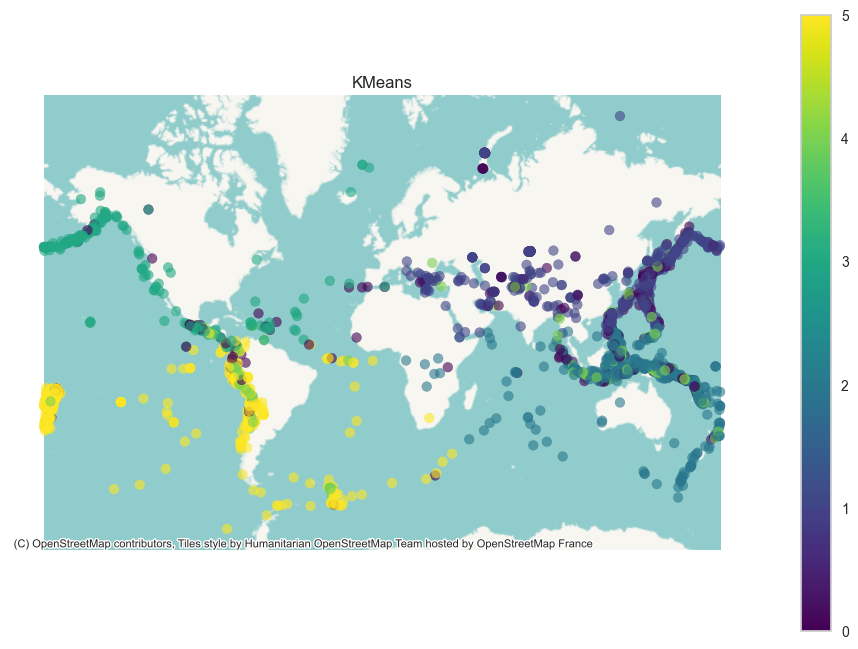

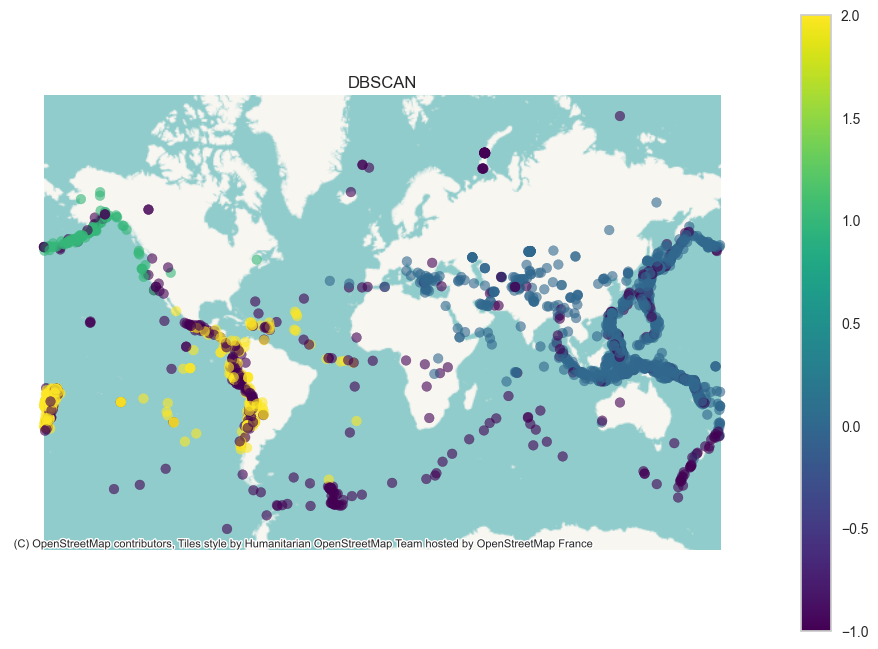

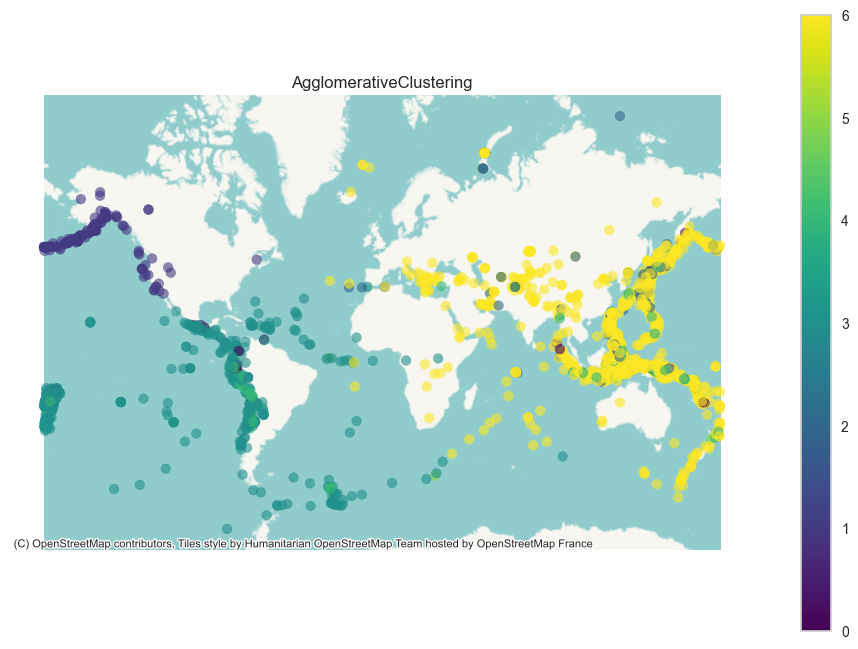

In [819]:
world_map('kmeans_6k_labels', 'KMeans')
world_map('dbscan_labels', 'DBSCAN')
world_map('hclust_labels', 'AgglomerativeClustering')

## Comments on world map visualisation

KMeans visualisation looks quite good, the clusters are approximately divided by the continents, different continents with different clusters, this might be justified since each region has unique levels of earthquakes

While Hieararchial was better than DBSCAN in metrics, in visualisation DBSCAN might look little better 

DBSCAN has relatively good division into clusters however most clusters have noises right inside them which should not have happened (Noise is the most purple dots)

Hiearchial might look over-generalised, it is divided into 3 main clusters which might not very appropriate in this case since, there more regions than 3. For example yellow takes whole asia and part of africa and australia while 

**OVERALL:**

KMEANS has better metrics and better visualisation in my opinion. Therefore it wins

Between DBSCAN and Hieararchial, hieararchial had better metrics while DBSCAN looks better on the map although it has noises within clusters. Thus, a confident decision can not be which one is better, they relatively had equal performance
